# Upgrade ISUP z biopsji
Przyjrzeć sie populacji pacjentów którzy mają w biopsji ISUP = 1 i jak często u nich występuje upgrade. ISUP 1 często się nie operuje bo uważa się go za nieistotnego klinicznie - muszą być inne przesłanki - fajnie by było znaleźć czynniki ryzyka, które powodują upgrade - że u tych pacjentów po prostatektomii wychodzi ISUP 2 i wiecej czyli nowotwór już klinicznie istotny

In [ ]:
import pandas as pd
import shap
from xgboost import XGBClassifier
import dalex as dx
from sklearn.metrics import roc_auc_score
from unified_functions import train_and_evaluate_model

from unified_functions import plot_roc, plot_confusion_matrix, plot_feature_importances, plot_discrimination_threshold

pd.options.display.max_columns = None

In [3]:
data = pd.read_csv('../materials/processed_df_new.csv')

In [4]:
isup_1 = data[data['Bx ISUP Grade'] == 1]
isup_1.head()

,ID,wiek,PSA,PSAdensity,MRI vol,MRI Pirads,MRI EPE,MRI EPE L,MRI EPE P,MRI SVI,MRI SVI L,MRI SVI P,MRI SIZE,Bx ISUP Grade P,Bx ISUP Grade L,ISUP RP,ISUP RP P,ISUP RP L,SM +,N +,EPE RP,EPE L RP,EPE P RP,SVI RP,SVI RP L,SVI RP P,TNM,EPE micro,EPE macro,EPE false_positive,Bx ISUP Grade
0,ID00000,63.0,5.11,0.146000,35.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,10.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2,0.0,0.0,1.0,1.0
2,ID00500,64.0,8.30,0.207500,40.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
5,ID00003,59.0,15.40,0.513333,30.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,1,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
8,ID00006,59.0,6.70,0.104688,64.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
10,ID00010,52.0,10.92,0.390000,28.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0


In [5]:
isup_1_upgraded = data[(data['Bx ISUP Grade'] == 1) & (data['ISUP RP'] >= 2)]
isup_1_upgraded.head()

,ID,wiek,PSA,PSAdensity,MRI vol,MRI Pirads,MRI EPE,MRI EPE L,MRI EPE P,MRI SVI,MRI SVI L,MRI SVI P,MRI SIZE,Bx ISUP Grade P,Bx ISUP Grade L,ISUP RP,ISUP RP P,ISUP RP L,SM +,N +,EPE RP,EPE L RP,EPE P RP,SVI RP,SVI RP L,SVI RP P,TNM,EPE micro,EPE macro,EPE false_positive,Bx ISUP Grade
2,ID00500,64.0,8.30,0.207500,40.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
5,ID00003,59.0,15.40,0.513333,30.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,1,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
11,ID00011,59.0,6.92,0.230667,30.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
12,ID00012,63.0,3.65,0.096053,38.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
21,ID00021,55.0,6.60,0.120000,55.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,1,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0


In [6]:
isup_1_not_upgraded = data[(data['Bx ISUP Grade'] == 1) & (data['ISUP RP'] == 1)]
isup_1_not_upgraded.head()

,ID,wiek,PSA,PSAdensity,MRI vol,MRI Pirads,MRI EPE,MRI EPE L,MRI EPE P,MRI SVI,MRI SVI L,MRI SVI P,MRI SIZE,Bx ISUP Grade P,Bx ISUP Grade L,ISUP RP,ISUP RP P,ISUP RP L,SM +,N +,EPE RP,EPE L RP,EPE P RP,SVI RP,SVI RP L,SVI RP P,TNM,EPE micro,EPE macro,EPE false_positive,Bx ISUP Grade
0,ID00000,63.0,5.11,0.146000,35.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,10.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2,0.0,0.0,1.0,1.0
8,ID00006,59.0,6.70,0.104688,64.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
10,ID00010,52.0,10.92,0.390000,28.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
13,ID00013,70.0,10.00,0.270270,37.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0
20,ID00020,52.0,3.80,0.111765,34.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t2c,0.0,0.0,0.0,1.0


In [7]:
isup_1["upgraded"] = (isup_1['ISUP RP'] > isup_1['Bx ISUP Grade']).astype(int)

In [8]:
isup_1["upgraded"].value_counts()

upgraded
1    103
0     67
Name: count, dtype: int64

Liczba pacjentów z ISUP 1 w biopsji: 170

Liczba pacjentów z ISUP 1 w biopsji i ISUP $\geqslant$ 2 po operacji: 103

Trenujemy model przewidujący czy występuje upgrade, aby pokazać najważniejsze kolumny dla modelu

In [34]:
drop_columns = ['Bx ISUP Grade', 'ISUP RP', 
                'Bx ISUP Grade P', 'ISUP RP P', 
                'Bx ISUP Grade L', 'ISUP RP L', 
                'EPE L RP', 'EPE P RP',
                'SVI RP L', 'SVI RP P',
                'MRI EPE L', 'MRI EPE P',
                'MRI SVI L', 'MRI SVI P',
                'EPE RP', 'SVI RP',
                'SM +', 'N +', 'TNM',
                'EPE micro', 'EPE macro', 'EPE false_positive',
                'upgraded',
                'ID',
                ]

In [35]:
X, y = isup_1.drop(columns=drop_columns), isup_1['upgraded']
numerical_cols = ['wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI SIZE']
categorical_cols = ['MRI Pirads', 'MRI EPE', 'MRI SVI']

In [36]:
res = train_and_evaluate_model(XGBClassifier(), X, y, numerical_cols, categorical_cols, n_folds=5)
y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, model_pipeline, best_params = res

Training model with default hyperparameters...

Fold 0:
ROC AUC score: 0.5892857142857142

Fold 1:
ROC AUC score: 0.4214285714285715

Fold 2:
ROC AUC score: 0.5421245421245421

Fold 3:
ROC AUC score: 0.4578754578754579

Fold 4:
ROC AUC score: 0.6373626373626373

Total scores:
ROC AUC score: 0.5297782930010143



In [ ]:
param_grid = {
    'classifier__n_estimators': [100, 200, 400, 800],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}
res = train_and_evaluate_model(XGBClassifier(), X, y, numerical_cols, categorical_cols, n_folds=5, param_grid=param_grid, tune_params=True, )


Tuning hyperparameters...

Best hyperparameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best roc_auc score: 0.6399421908681168

Model hyperparameters after tuning: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0.2, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs':

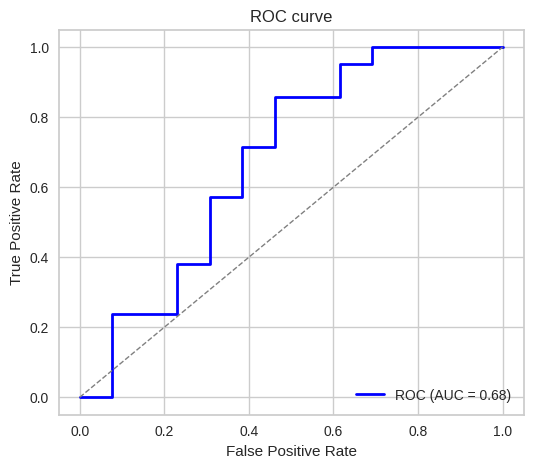

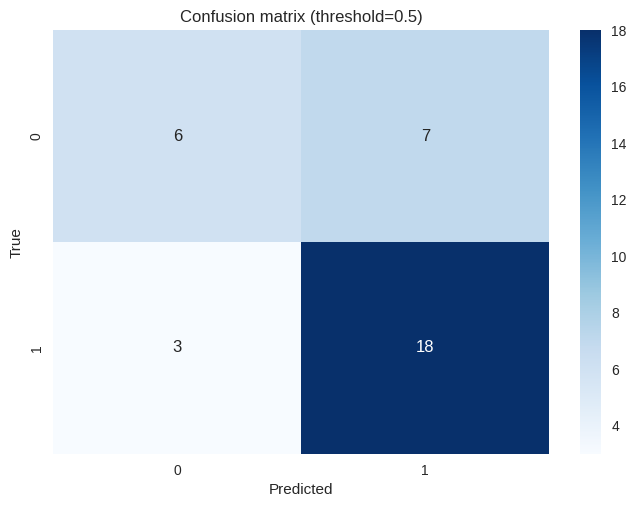

Sensitivity: 0.8571
Specificity: 0.4615
Accuracy: 0.7059%
Preparation of a new explainer is initiated

  -> data              : 170 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 170 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x74f44e16ca40> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.411, mean = 0.601, max = 0.795
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.795, mean = 0.00482, max = 0.532
  -> model_info        : package sklearn

A new explainer has been created!


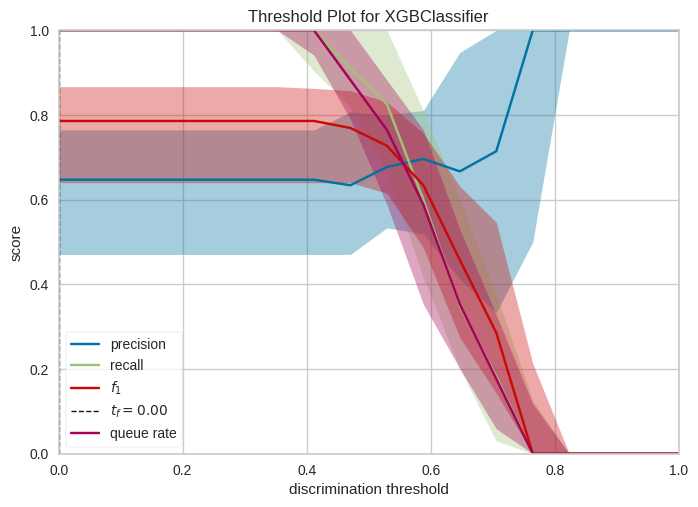

In [39]:
y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, model_pipeline, best_params = res
plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(model_pipeline, X, y)
plot_discrimination_threshold(model_pipeline, X, y)